In [1]:
%pylab inline
import xgboost as xgb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.linear_model import LogisticRegression
import clustering as cl
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set(style='whitegrid', rc={'figure.figsize':(11.7,8.27)})
sns.set_context('talk', rc={ 'lines.linewidth': 6}, font_scale=1.5)

In [3]:
X_with_columns = pd.read_pickle("pickle_files/X.pkl")
Z_with_columns = pd.read_pickle("pickle_files/Z.pkl")

columns_to_drop = []

X_with_columns.drop(columns_to_drop, axis = 1, inplace=True)
Z_with_columns.drop(columns_to_drop, axis = 1, inplace=True)

X = np.array(X_with_columns)
Y = np.array(pd.read_pickle("pickle_files/Y.pkl"))
Z = np.array(Z_with_columns)
df_next_games = pd.read_pickle("pickle_files/next_games.pkl")

In [4]:
X.shape

(1495, 46)

In [5]:
Y.shape

(1495,)

In [6]:
pd.Series(Y).value_counts()

3.0    670
1.0    463
2.0    362
dtype: int64

In [7]:
kf = KFold(n_splits=4, random_state=0, shuffle=True)
kf.get_n_splits(X)

4

In [8]:
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

TRAIN: [   0    3    6 ... 1491 1492 1493] TEST: [   1    2    4    5    9   14   18   19   22   27   29   31   34   39
   40   45   47   52   53   54   55   56   58   61   75   80   82   85
   89   92   96  107  108  113  114  122  124  140  141  142  148  152
  156  159  161  175  178  182  184  186  187  191  192  198  202  204
  211  215  218  219  220  223  224  227  231  233  241  247  253  254
  260  268  270  278  279  295  298  299  302  303  308  309  310  315
  317  319  322  326  330  333  342  347  353  354  360  361  362  364
  376  381  390  393  408  412  414  422  425  427  434  435  436  438
  440  442  443  446  458  465  467  471  473  477  481  482  483  494
  501  511  512  513  516  517  520  526  527  529  530  536  539  540
  548  549  554  558  563  567  568  574  575  579  580  581  587  590
  601  602  609  615  619  620  621  629  632  641  642  646  648  651
  654  655  656  657  667  670  674  678  681  682  688  693  695  704
  708  712  716  717  720  7

## XGBoost

In [9]:
XGB_model = xgb.XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.005,  
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      objective='multi:softprob', 
                      n_estimators=1000, 
                      reg_alpha = 0.2,
                      max_depth=5, 
                      gamma=5,
                      seed=82)

In [10]:
XGB_model.fit(X_train, y_train)
y_pred = XGB_model.predict(X_test)
y_pred_train = XGB_model.predict(X_train)
accuracy = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, y_pred_train)

[20:29:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { scale_pos_weight, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [11]:
y_pred.shape

(373,)

In [12]:
pd.Series(y_pred).value_counts()

3.0    237
1.0    115
2.0     21
dtype: int64

## LogisticRegression

In [13]:
LR = LogisticRegression(random_state = 42)
LR.fit(X_train, y_train)
LR_y_pred = LR.predict(X_test)
LR_y_pred_train = LR.predict(X_train)
LR_accuracy = accuracy_score(y_test, LR_y_pred)
LR_accuracy_train = accuracy_score(y_train, LR_y_pred_train)

In [14]:
pd.Series(LR_y_pred).value_counts()

3.0    211
1.0    116
2.0     46
dtype: int64

## Comparassion

In [15]:
print("XGB train Accuracy: %.2f%%" % (accuracy_train * 100.0))
print("XGB Accuracy: %.2f%%" % (accuracy * 100.0))
print("LR train Accuracy: %.2f%%" % (LR_accuracy_train * 100.0))
print("LR Accuracy: %.2f%%" % (LR_accuracy * 100.0))

XGB train Accuracy: 74.15%
XGB Accuracy: 68.63%
LR train Accuracy: 75.31%
LR Accuracy: 72.39%


In [16]:
features_names = list(X_with_columns.columns)

In [17]:
importance = np.round(XGB_model.feature_importances_,4)
dictionary = dict(zip(features_names, importance))
sorted_dictionary=sorted(dictionary.items(), key=lambda x:x[1], reverse=True)
names=[]
values=[]
for i in range(0, len(importance)):
    print('Feature Importance: {:35} {}%'.format(
        sorted_dictionary[i][0], np.round(sorted_dictionary[i][1]*100,4))
         )
    names.append(sorted_dictionary[i][0])
    values.append(np.round(sorted_dictionary[i][1]*100,4))

Feature Importance: AVGHTGDIFF                          4.14%
Feature Importance: odds_ft_away_team_win               4.05%
Feature Importance: AVGATGDIFF                          3.98%
Feature Importance: odds_ft_home_team_win               3.75%
Feature Importance: odds_ft_over25                      3.48%
Feature Importance: awt_3                               3.39%
Feature Importance: odds_ft_draw                        3.05%
Feature Importance: away_ppg                            2.8%
Feature Importance: home_ppg                            2.73%
Feature Importance: A_AVGATGDIFF_1                      2.56%
Feature Importance: H_AVGHTGDIFF_1                      2.46%
Feature Importance: ht_0                                2.43%
Feature Importance: awt_1                               2.37%
Feature Importance: attendance                          2.34%
Feature Importance: awt_2                               2.11%
Feature Importance: A_ATGDIFF_1                         2.06%
Feature I

In [18]:
cum_values = np.cumsum(values)
values_over_95 = (cum_values > 95).sum()
columns_over_95 = names[-values_over_95:]
columns_over_95

['over_45_percentage_pre_match',
 'btts_percentage_pre_match',
 'over_15_percentage_pre_match',
 'odds_ft_over45',
 'ht_3']

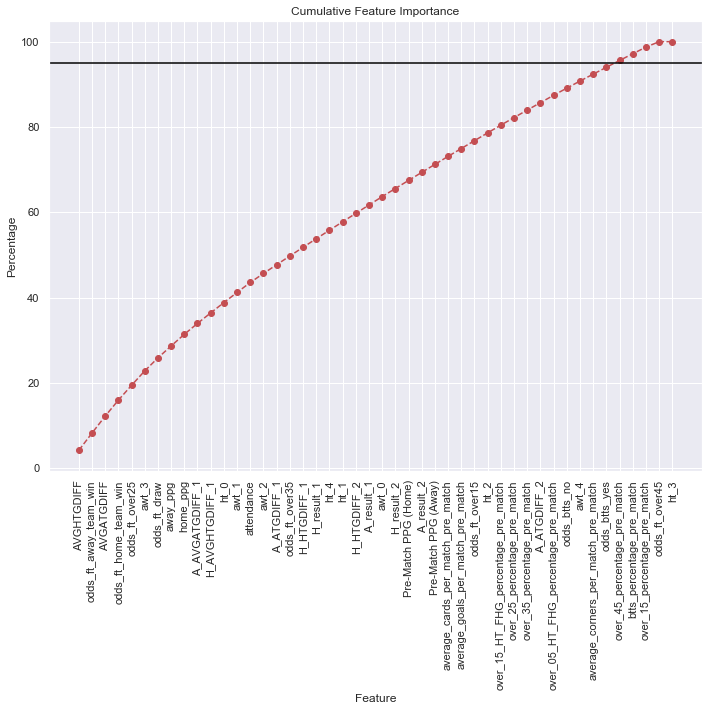

In [19]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
bottom, top = ylim()
bottom = 0
plt.plot(names,cum_values, '--bo', color='r')
# set importance at 95%
plt.axhline(95,color='black')
plt.xticks(rotation=90);
plt.xlabel('Feature'); 
plt.ylabel('Percentage'); 
plt.title('Cumulative Feature Importance');

## Predict Result for Next Games

In [20]:
z_pred = XGB_model.predict(Z)

In [21]:
xgb_df_next_games = df_next_games.copy()

In [22]:
xgb_df_next_games['predicted_result'] = z_pred

In [23]:
xgb_df_next_games['tipico quota']=0
xgb_df_next_games['R']=False

In [24]:
lr_z_pred = LR.predict(Z)

In [25]:
lr_df_next_games = df_next_games.copy()

In [26]:
lr_df_next_games['predicted_result'] = lr_z_pred

In [27]:
import sqlite3
# Create your connection.
cnx1 = sqlite3.connect('data1.db')

### Check Before Save in DB

In [31]:
xgb_df_next_games

,home_team_name,away_team_name,predicted_result,tipico quota,R
1512,Bayern München,Freiburg,3.0,0,False
1513,RB Leipzig,Borussia Dortmund,1.0,0,False
1514,Hoffenheim,Union Berlin,3.0,0,False
1515,Fortuna Düsseldorf,Augsburg,1.0,0,False
1516,Hertha BSC,Bayer Leverkusen,1.0,0,False
1517,Mainz 05,Werder Bremen,1.0,0,False
1518,Schalke 04,Wolfsburg,1.0,0,False
1519,Köln,Eintracht Frankfurt,1.0,0,False
1520,Paderborn,Borussia M'gladbach,1.0,0,False


In [32]:
# xgb_df_next_games.to_sql(name='xgb_df_next_games', con=cnx1,if_exists='append')

# Access SQLite DB

### Delete

In [29]:
# def deleteRecord():
#     try:
#         sqliteConnection = sqlite3.connect('data1.db')
#         cursor = sqliteConnection.cursor()
#         print("Connected to SQLite")

#         # Deleting single record now
#         sql_delete_query = """DELETE from xgb_df_next_games where rowid > 9"""
#         cursor.execute(sql_delete_query)
#         sqliteConnection.commit()
#         print("Record deleted successfully ")
#         cursor.close()

#     except sqlite3.Error as error:
#         print("Failed to delete record from sqlite table", error)
#     finally:
#         if (sqliteConnection):
#             sqliteConnection.close()
#             print("the sqlite connection is closed")

# deleteRecord()

### Read

In [34]:
df = pd.read_sql_query("SELECT * from xgb_df_next_games", cnx1)